<a href="https://colab.research.google.com/github/ttyo/ARS/blob/master/Copy_of_fastai_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#JupyterNB-Preparation" data-toc-modified-id="JupyterNB-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>JupyterNB Preparation</a></span></li><li><span><a href="#fast.ai-lib-imports" data-toc-modified-id="fast.ai-lib-imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>fast.ai lib imports</a></span></li><li><span><a href="#Check-that-CUDA-and-CUDNN-are-working" data-toc-modified-id="Check-that-CUDA-and-CUDNN-are-working-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check that CUDA and CUDNN are working</a></span></li><li><span><a href="#Establish-path-to-data" data-toc-modified-id="Establish-path-to-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Establish path to data</a></span></li><li><span><a href="#Check-that-the-folder-structure-has-the-proper-setup-(train,-valid)" data-toc-modified-id="Check-that-the-folder-structure-has-the-proper-setup-(train,-valid)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Check that the folder structure has the proper setup (train, valid)</a></span></li><li><span><a href="#Model-quick-start" data-toc-modified-id="Model-quick-start-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model quick start</a></span></li><li><span><a href="#Analyzing-results:-looking-at-pictures" data-toc-modified-id="Analyzing-results:-looking-at-pictures-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Analyzing results: looking at pictures</a></span></li><li><span><a href="#Choosing-a-learning-rate" data-toc-modified-id="Choosing-a-learning-rate-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Choosing a learning rate</a></span></li><li><span><a href="#Improving-our-model" data-toc-modified-id="Improving-our-model-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Improving our model</a></span><ul class="toc-item"><li><span><a href="#Fine-tuning-and-differential-learning-rate-annealing" data-toc-modified-id="Fine-tuning-and-differential-learning-rate-annealing-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Fine-tuning and differential learning rate annealing</a></span></li></ul></li></ul></div>

## JupyterNB Preparation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## fast.ai lib imports

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
plt.style.use(['dark_background'])

ModuleNotFoundError: ignored

## Check that CUDA and CUDNN are working

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.backends.cudnn.enabled

True

In [ ]:
# See how many devices are around
torch.cuda.device_count()

2

In [ ]:
# Check which device you are on
torch.cuda.current_device()

1

In [ ]:
# Set it to a particular device
torch.cuda.set_device(1)

In [ ]:
# Check which device you are on
torch.cuda.current_device()

1

## Establish path to data

PATH is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. sz is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at 224 for now.

In [ ]:
PATH = "data/ViewPorts/"

## Check that the folder structure has the proper setup (train, valid)

In [ ]:
os.listdir(PATH)

['sample', 'test1', '.ipynb_checkpoints', 'valid', 'train', 'models', 'tmp']

In [ ]:
os.listdir(f'{PATH}valid')

['buy', 'sell']

First look at the images

In [ ]:
files = os.listdir(f'{PATH}valid/buy')[:5]
files

['buy.356.png', 'buy.357.png', 'buy.423.png', 'buy.92.png', 'buy.181.png']

Size of training set

In [ ]:
print ("Size of TRAIN set - buy: " + str(len(os.listdir(f'{PATH}train/buy'))) + " records")
print ("Size of TRAIN set - sell: " + str(len(os.listdir(f'{PATH}train/sell'))) + " records")
print ("____________")
print ("Size of VALID set - buy: " + str(len(os.listdir(f'{PATH}valid/buy'))) + " records")
print ("Size of VALID set - sell: " + str(len(os.listdir(f'{PATH}valid/sell'))) + " records")

Size of TRAIN set - buy: 16251 records
Size of TRAIN set - sell: 16522 records
____________
Size of VALID set - buy: 139 records
Size of VALID set - sell: 133 records


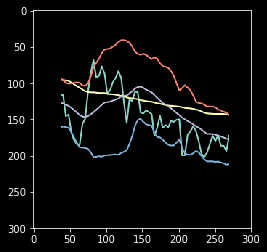

In [ ]:
img = plt.imread(f'{PATH}valid/buy/{files[0]}')
plt.imshow(img);

Check how the raw data looks like

In [ ]:
img.shape

(300, 300, 4)

In [ ]:
img[:4,:4]

array([[[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]]], dtype=float32)

## Model quick start

In [ ]:
sz=300
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
# tried to use multiple GPUs, does not work for now
#learn.models.model = torch.nn.DataParallel(learn.models.model,device_ids=[0, 1])
print ("Size of image is: "+ str(sz))
learn.fit(0.01, 50)

100%|██████████| 5/5 [00:01<00:00,  3.47it/s]
Size of image is: 300


HBox(children=(IntProgress(value=0, description='Epoch', max=50), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.770454   0.709416   0.5375    
    1      0.764882   0.756307   0.4375                      
    2      0.766007   0.71079    0.475                       
    3      0.746671   0.735118   0.4625                      
    4      0.74235    0.713715   0.54375                     
    5      0.737498   0.707884   0.5125                      
    6      0.743434   0.715835   0.515625                    
    7      0.728898   0.723579   0.4625                      
    8      0.724317   0.716341   0.471875                    
    9      0.713333   0.698305   0.5375                      
    10     0.718798   0.722517   0.475                       
    11     0.71402    0.708751   0.5                         
    12     0.709003   0.684149   0.559375                    
    13     0.702224   0.715033   0.46875                     
    14     0.703716   0.704247   0.484375                    
    15     0.712132   0.6

KeyboardInterrupt: 

## Analyzing results: looking at pictures


As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [ ]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
# from here we know that 'sell' is label 0 and 'buy' is label 1.
data.classes

['buy', 'sell']

In [ ]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(272, 2)

In [ ]:
log_preds[:10]

array([[-0.89829, -0.52301],
       [-0.69973, -0.68661],
       [-0.61983, -0.77227],
       [-0.5367 , -0.8787 ],
       [-0.63084, -0.75959],
       [-0.67013, -0.71671],
       [-0.65822, -0.72934],
       [-0.6544 , -0.73345],
       [-0.59757, -0.79883],
       [-0.78844, -0.60615]], dtype=float32)

In [ ]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(win)

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


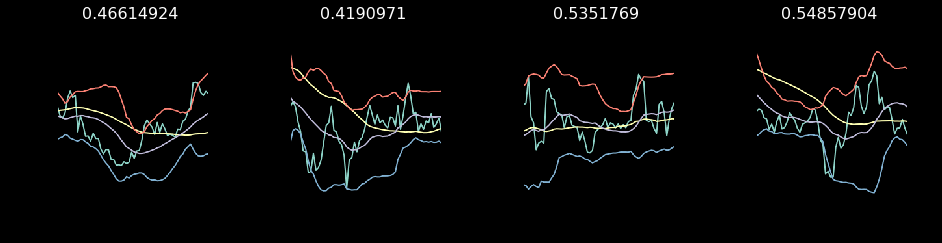

In [ ]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


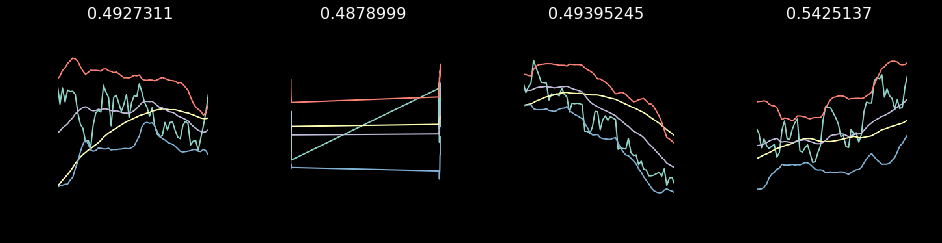

In [ ]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct sell


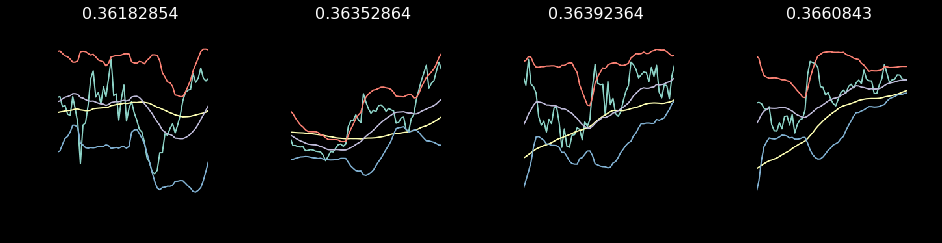

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct sell")

Most correct buy


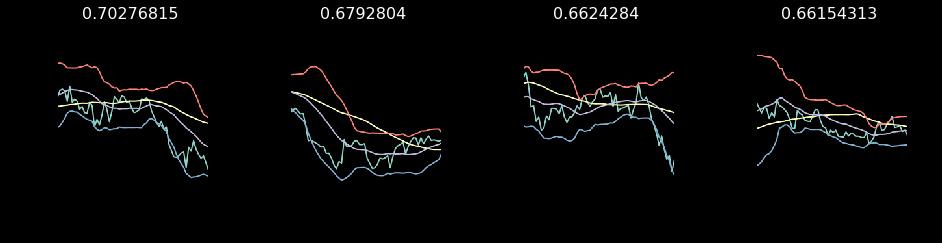

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct buy")

Most incorrect sell


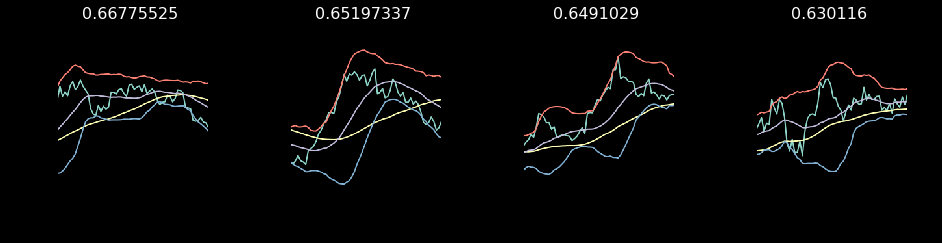

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect sell")

Most incorrect buy


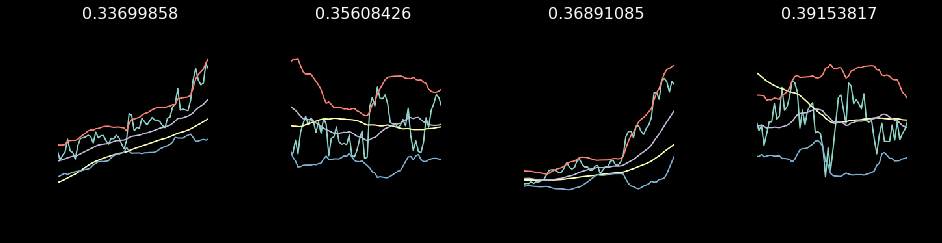

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect buy")

Most uncertain predictions


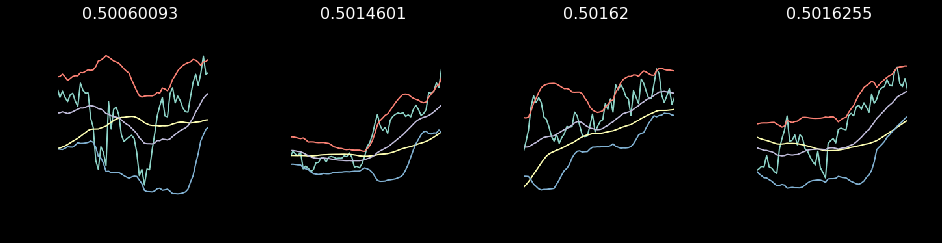

In [ ]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
lrf=learn.lr_find()

Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

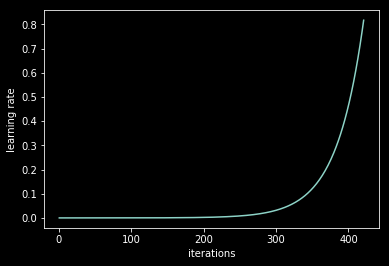

In [ ]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

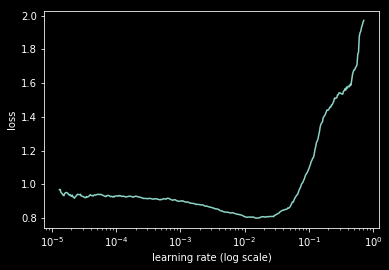

In [ ]:
learn.sched.plot()

## Improving our model

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [ ]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [ ]:
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

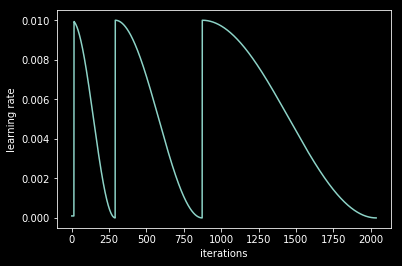

In [ ]:
learn.sched.plot_lr()

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
accuracy_np(probs, y)

0.4889705882352941